### Simulaciones de trayectorías (plásticos)


## Introducción

Comprender las trayectorias en el océano es importante para varias aplicaciones, como la contaminación marina por plásticos, pero también para otros contaminantes oceánicos como los derrames de petróleo o para estudios de ecología marina para comprender la conectividad de las especies marinas. Las simulaciones Lagrangianas son una  herramienta potente para obtener trayectorias marinas. Una de las herramientas de software abierto que existen es OceanParcels. Usando como entrada campos de velocidad, como los que vimos en el tutorial anterior (por ejemplo, productos altimetría satelital de la superficie del mar), podemos obtener fácilmente trayectorias de partículas con diferentes características.

<!-- Here will look at an example of a Lagrangian simulation..... -->

¿Quieres saber más detalles sobre OceanParcels? Más info. [aquí].(https://docs.oceanparcels.org/en/latest/index.html)


También puede explorar el simulador en línea [plastic adrift](https://plasticadrift.org/)!!

## ¿Cómo funciona?

### Características de la simulación:
* Duración (runtime): 30 días
* Número de partículas: 144 (1 por punto de malla en nuestra subregión de estudio)

In [1]:
%matplotlib inline

import numpy as np
import math
from datetime import timedelta
from operator import attrgetter
import xarray as xr
from parcels import FieldSet, ParticleSet, Variable, JITParticle, AdvectionRK4

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker


In [2]:
# from urllib.request import urlretrieve 

# currentfile = "cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_1731678780714.nc"

# if not(os.path.exists(currentfile)):
#     urlretrieve("https://dox.uliege.be/index.php/s/mZLCV3TIbqr1Vqw/download", currentfile)

# datacurrent = xr.open_dataset(currentfile)
# datacurrent

# lon2d, lat2d = np.meshgrid(datacurrent["longitude"].values, datacurrent["latitude"].values)
# u =  datacurrent["uo"][0,0,:,:]
# v =  datacurrent["vo"][0,0,:,:]
# magnitude = (u ** 2 + v ** 2) ** 0.5

# Campos de entrada (input fields):

Usaremos los campos de velocidad de .. We will use the L4 dataset again.

In [3]:
filedir = '/Users/Gomez023/Downloads/'#'../content/drive/MyDrive/Altimetry/L4/'

In [4]:
!ls -trl /Users/Gomez023/Downloads/*.nc | tail

-rw-r--r--@ 1 Gomez023  staff    9859956 Nov 20 20:39 /Users/Gomez023/Downloads/dt_global_allsat_phy_l4_20180906_20210726.nc
-rw-r--r--@ 1 Gomez023  staff    9858398 Nov 20 20:39 /Users/Gomez023/Downloads/dt_global_allsat_phy_l4_20180907_20210726.nc
-rw-r--r--@ 1 Gomez023  staff    9859746 Nov 20 20:39 /Users/Gomez023/Downloads/dt_global_allsat_phy_l4_20180908_20210726.nc
-rw-r--r--@ 1 Gomez023  staff    9858852 Nov 20 20:39 /Users/Gomez023/Downloads/dt_global_allsat_phy_l4_20180909_20210726.nc
-rw-r--r--@ 1 Gomez023  staff    9857931 Nov 20 20:39 /Users/Gomez023/Downloads/dt_global_allsat_phy_l4_20180910_20210726.nc
-rw-r--r--@ 1 Gomez023  staff    9860387 Nov 20 20:39 /Users/Gomez023/Downloads/dt_global_allsat_phy_l4_20180911_20210726.nc
-rw-r--r--@ 1 Gomez023  staff    9860657 Nov 20 20:39 /Users/Gomez023/Downloads/dt_global_allsat_phy_l4_20180912_20210726.nc
-rw-r--r--@ 1 Gomez023  staff    9858516 Nov 20 20:39 /Users/Gomez023/Downloads/dt_global_allsat_phy_l4_20180913_20210726.nc


## Primero cargamos un fichero de ejemplo::

In [5]:
ds_m = xr.open_dataset(filedir + "dt_global_allsat_phy_l4_20180906_20210726.nc")

In [6]:
ds_m

<xarray.Dataset>
Dimensions:         (latitude: 720, longitude: 1440, nv: 2, time: 1)
Coordinates:
  * time            (time) datetime64[ns] 2018-09-06
  * latitude        (latitude) float32 -89.88 -89.62 -89.38 ... 89.62 89.88
  * longitude       (longitude) float32 -179.9 -179.6 -179.4 ... 179.6 179.9
  * nv              (nv) int32 0 1
Data variables:
    crs             int32 ...
    lat_bnds        (latitude, nv) float32 ...
    lon_bnds        (longitude, nv) float32 ...
    sla             (time, latitude, longitude) float64 ...
    err_sla         (time, latitude, longitude) float64 ...
    ugosa           (time, latitude, longitude) float64 ...
    err_ugosa       (time, latitude, longitude) float64 ...
    vgosa           (time, latitude, longitude) float64 ...
    err_vgosa       (time, latitude, longitude) float64 ...
    adt             (time, latitude, longitude) float64 ...
    ugos            (time, latitude, longitude) float64 ...
    vgos            (time, latitude, longitude) float64 ...
    flag_ice        (time, latitude, longitude) float64 ...
    tpa_correction  (time) float64 ...
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    creator_name:                    CMEMS - Sea Level Thematic Assembly Center
    creator_url:                     http://marine.copernicus.eu
    date_created:                    2021-07-27T12:53:58Z
    date_issued:                     2021-07-27T12:53:58Z
    date_modified:                   2021-07-27T12:53:58Z
    geospatial_lat_max:              89.875
    geospatial_lat_min:              -89.875
    geospatial_lat_resolution:       0.25
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              179.875
    geospatial_lon_min:              -179.875
    geospatial_lon_resolution:       0.25
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2021-07-27 12:54:00Z: Creation
    institution:                     CLS, CNES
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://marine.copernicus.eu/web/27-servi...
    platform:                        Altika Drifting Phase, Cryosat-2, Haiyan...
    processing_level:                L4
    product_version:                 vDec2021
    project:                         COPERNICUS MARINE ENVIRONMENT MONITORING...
    references:                      http://marine.copernicus.eu
    software_version:                7.0_DUACS_DT2021_baseline
    source:                          Altimetry measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2018-09-06T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             2018-09-05T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

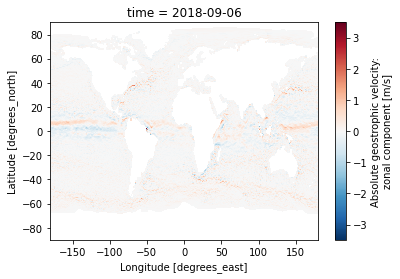

In [7]:
ds_m.ugos[0,:,:].plot()

## Seleccionamos una subzona:

In [8]:
lon_min = -100
lon_max = -75
lat_min = 2
lat_max = 10

In [9]:
ds_m_sub = ds_m.where((ds_m.longitude<lon_max)&(ds_m.longitude>lon_min)&(ds_m.latitude<lat_max)&(ds_m.latitude>lat_min), drop=True)


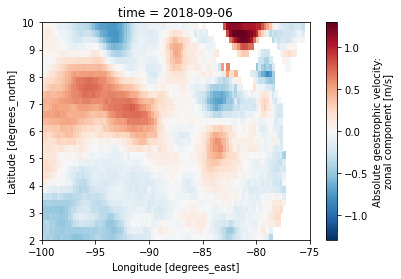

In [10]:
ds_m_sub.ugos[0,:,:].plot()

## Cargamos el "fieldset" (campo de velocidad) para las simulaciones:

In [11]:
ficheros = {'U': filedir + "dt_global_allsat_phy_l4_201809[0-1]?_*.nc",
             'V': filedir + "dt_global_allsat_phy_l4_201809[0-1]?_*.nc"}


### Usamos la velocidad Euleriana, así que elegimos las variables ugos y vgos:

In [12]:
variables = {'U': 'ugos',
             'V': 'vgos'}

dimensiones = {'lat': 'latitude',
              'lon': 'longitude',
              'time': 'time'}

In [13]:
fieldset = FieldSet.from_netcdf(ficheros, variables, dimensiones, deferred_load=False)

# Definimos los parámetros de la simulación:

## ¿Cuántas y dónde queremos lanzar las partículas?

### Opción A) Definimos las longitudes y latitudes.
### Por ejemple, lanzamos las partículas sobre una línea:

In [14]:
lat1D = np.arange(4, 6, .1) # (inicio, fin + incremento, incremento)
lon1D = np.ones_like(lat1D) * -90.

pset_A = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lon1D, lat=lat1D)


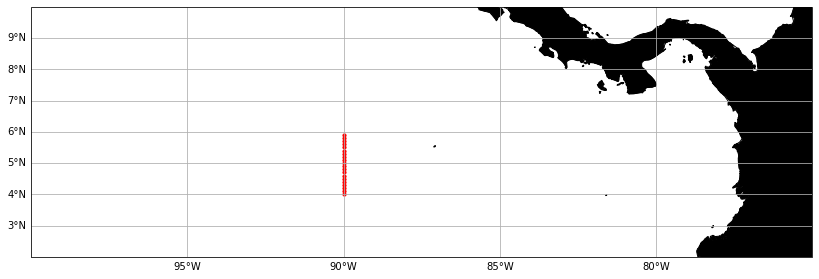

In [15]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor='black') # si el codigo tarda mucho, se puede comentar esta línea
ax1.scatter(pset_A.lon, pset_A.lat, c='r', s=10, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([lon_min, lon_max])
ax1.set_ylim([lat_min, lat_max])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


### Opción B) Lanzamos 1 partícula en cada punto de malla del "fieldset"


In [16]:
lon1D = fieldset.U.lon[np.arange(260, 270, 1)]
lat1D = fieldset.U.lat[np.arange(140, 150, 1)]

lons, lats = np.meshgrid(lon1D, lat1D)
pset_B = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats)


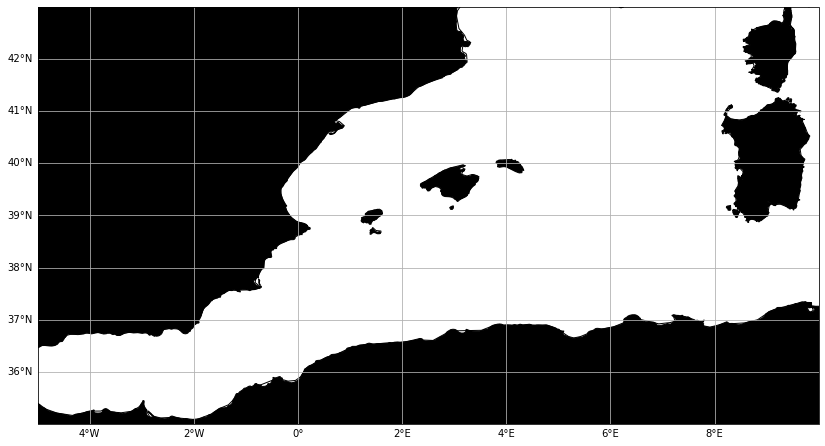

In [17]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor='black') # si el codigo tarda mucho, se puede comentar esta línea
ax1.scatter(pset_B.lon, pset_B.lat, c='r', s=10, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([-5, 10])
ax1.set_ylim([35, 43])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


## Otros parámetros:

In [18]:
runtime_days = 10

In [19]:
fichero_salida = "lag_simu_pset_A_test01" #.zarr

In [20]:

output_file = pset_A.ParticleFile(name=fichero_salida, outputdt=timedelta(hours=24))
pset_A.execute(pset_A.Kernel(AdvectionRK4),
             runtime=timedelta(days=runtime_days),
             dt=timedelta(minutes=25),
             output_file=output_file)

INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/54/mb8qg4_j53d9_q2jnv7n8sjc0000gn/T/parcels-501/6bc476cec7d808011856eee2ab404a68_0.so


In [21]:
!ls -trl

total 1824
-rw-r--r--@ 1 Gomez023  staff  492011 Nov 20 20:42 simulaciones_trayectorias-plasticos.ipynb
-rw-r--r--  1 Gomez023  staff   12052 Nov 20 20:46 lag_simu_pset_A_test01.zarr.nc
-rw-r--r--  1 Gomez023  staff  402380 Nov 20 20:54 simulaciones_trayectorias-plasticos-Copy1.ipynb
drwxr-xr-x  3 Gomez023  staff      96 Nov 20 20:55 out-CDTWZCWD
-rw-r--r--  1 Gomez023  staff   16532 Nov 20 20:55 lag_simu_pset_A_test01.nc
drwxr-xr-x  3 Gomez023  staff      96 Nov 20 20:55 out-MBLQSWHH


# Echemos un vistazo a las trayectorias generadas:

In [22]:
ds = xr.open_dataset("lag_simu_pset_A_test01.nc")

In [23]:
ds

<xarray.Dataset>
Dimensions:     (obs: 11, traj: 20)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.1
    parcels_mesh:           spherical

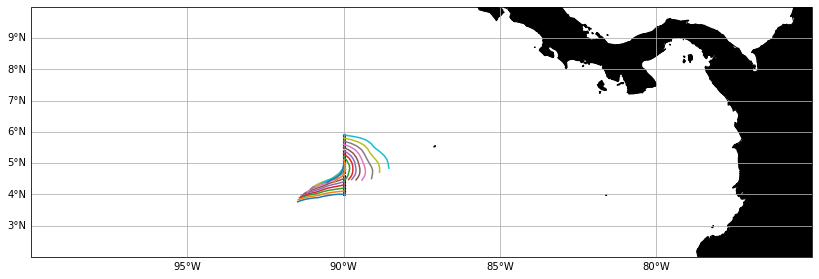

In [24]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
ax1.add_feature(cartopy.feature.LAND, facecolor='black') # si el codigo tarda mucho, se puede comentar esta línea
ax1.plot(ds['lon'].T, ds['lat'].T, transform=ccrs.PlateCarree())
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=5, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([lon_min, lon_max])
ax1.set_ylim([lat_min, lat_max])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


## Graficamos las partículas en el último paso de tiempo con la velocidad zonal de fondo:

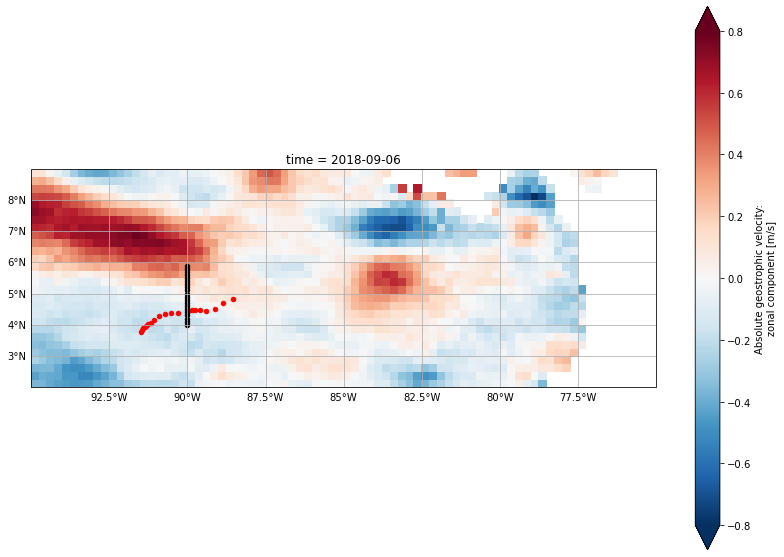

In [28]:
plt.figure(figsize=(14,10))

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ds_m.ugos[0,:,:].plot(vmin=-.8, vmax=.8, cmap='RdBu_r')
ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], c='r', s=20, transform=ccrs.PlateCarree(), label='End')
ax1.scatter(ds['lon'][:,0], ds['lat'][:,0], c='k', s=20, transform=ccrs.PlateCarree(), label='Start')
ax1.set_xlim([-95, lon_max])
ax1.set_ylim([lat_min, 9])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


# Referencias

Laura Gomez-Navarro, & Paul Hargous. (2024). IMEDEA-AP-LAB/MASS24_Altimetry_tutorial: v1.0.0 (v1.0.0). Zenodo. https://doi.org/10.5281/zenodo.13962687